<a href="https://colab.research.google.com/github/jugernaut/Numerico2021/blob/desarrollo/08_MonteCarlo/CudaNumbaParalelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="Teal" face="Comic Sans MS,arial">
  <h1 align="center"><i>Programación en Paralelo</i></h1>
  </font>
  <font color="Black" face="Comic Sans MS,arial">
  <h5 align="center"><i>Profesor: M.en.C. Miguel Angel Pérez León.</i></h5>
    <h5 align="center"><i>Ayudante: Jesús Iván Coss Calderón.</i></h5>
  <h5 align="center"><i>Materia: Análisis Numérico.</i></h5>
  </font>

# Introducción

Todos los algoritmos vistos en el curso se han descrito de manera [secuencial](https://desarrolloweb.com/articulos/2199.php), sin embargo muchos de ellos pueden ser redefinidos en su forma en **paralelo**.

¿Por qué nos debería interesar programar en paralelo?, bueno la respuesta es muy sencilla, la gran mayoría (si no es que todas) de las aplicaciones que usamos actualmente son desarrolladas usando alguna técnica de programación en paralelo.

¿Cuál es la principal ventaja de la programación en paralelo?, **la velocidad con la que este se ejecuta**, es decir el tiempo de ejecución. Un algoritmo en paralelo, debido a que distribuye los cálculos (FLOP's) entre los distintos dispositivos de cómputo tiende a reducir el tiempo de ejecución.

CUDA (estandar de programación en paralelo basado en el lenguaje C) tiene un modelo de ejecución diferente al modelo secuencial tradicional utilizado para programar usando los CPU's disponibles. En CUDA, el código que escribes será ejecutado por varios subprocesos a la vez (a menudo cientos o miles dentro de la GPU), a diferencia de la programación secuencial en la cual cada [proceso](http://tecnologiasifa4b.blogspot.com/2015/08/proceso-computacional.html#:~:text=Un%20proceso%20computacional%20es%20u,de%20recursos%20del%20sistema%20asociados.&text=La%20ejecuci%C3%B3n%2C%20desde%20un%20proceso,la%20creaci%C3%B3n%20de%20otro%20proceso.) es ejecutado uno a la vez por cada CPU. Su solución se modelará definiendo una jerarquía de subprocesos de cuadrícula, bloques e subprocesos.

El soporte CUDA de Numba Numba ([envoltorio](https://es.wikipedia.org/wiki/Wrapper) de CUDA para python) expone las instalaciones para declarar y administrar esta jerarquía de subprocesos. Las instalaciones y prestaciones son muy similares a las expuestas por el lenguaje C CUDA de NVidia.

## CPU v.s. GPU

Actualmente los dispositivos de cómputo contienen al menos un CPU y dentro de este CPU pueden estar contenidos varios nucleos, lo que permite el desarrolo de algoritmos en paralelo.

De igual, la mayoria de los dispositivos de cómputo contienen al menos un GPU y dentro de este GPU pueden existir varios nucleos, la principal diferencia entre ambos (CPU y GPU) es el proposito para el cuál fueron diseñados

Para fines prácticos (y del curso) podemos pensar que la diferencia principal entre una CPU (unidad de procesamiento central) y una GPU (**unidad de procesamiento gráfico**) radíca en que un CPU es un dispositivo de cómputo de proposito general, puede realizar cualquier tipo de cómputo que se le asigne.

Por otro lado un GPU esta diseñado para el procesamiento gráfico, lo que significa que la forma en la que procesa información **esta optimizada para trabajar con matrices y vectores**.

<center>
<img src="https://github.com/jugernaut/Numerico2021/blob/desarrollo/Figuras/MonteCarlo/cpu-vs-gpu.jpg?raw=1" width="600"> 
</center>

<center>
<img src="https://github.com/jugernaut/Numerico2021/blob/desarrollo/Figuras/MonteCarlo/mejor.png?raw=1" width="600"> 
</center>

## ¿Qué es Numba?

Según la documentación de Numba, "Numba es un compilador justo a tiempo para Python que funciona mejor en código que usa matrices y funciones de NumPy, y ciclos.

En otras palabras, Numba es una paqueteria (igual que Numpy o Matplotlib) que nos ayuda a que nuestros algoritmos se ejecuten de forma optimizada y en particular nos permite tener acceso a los GPU's disponibles en el hardware que estemos ejecutando nuestros algoritmos.

La forma más común de usar Numba es a través de su colección de *decoradores* que se pueden aplicar a sus funciones para indicarle a Numba que las compile. Cuando se realiza una llamada a una función decorada de Numba, **se compila en código máquina** "justo a tiempo" para su ejecución y todo o parte de su código puede ejecutarse posteriormente a la ¡velocidad del código máquina nativo!.

Para nuestros propósitos de hoy, Numba es un paquete de Python que le permite escribir código Python para GPU.

# Accediendo a la GPU de google colab

1.   Para ejecutar las funciones de Numba usando las GPU's gratuitas de Google, tenemos que hacer un par de cosas. Primero, ir al menú *Runtime o Entorno de ejecución*, seleccionar *Cambiar tipo de tiempo de ejecución*, y en el cuadro emergente, en *Acelerador de hardware*, seleccione *GPU*, guardamos el cambio y listo.
2.   Idealmente, eso es todo lo que deberíamos tener que hacer. Pero en la práctica, aunque las bibliotecas CUDA están instaladas, en el momento de escribir este jupyter, Colab no puede encontrarlas automáticamente. Entonces, hay que averiguar dónde están y luego indicarle a Colab.

In [ ]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-10.1/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so
/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so


Se debe seleccionar y pegar la ubicación de las bibliotecas en el siguiente cuadro de código (de preferencia elegir las versiones más recientes):

In [ ]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.1/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so"

Una vez que ya se le indicó a colab donde encontrar las bibliotecas necesarias, podemos pasar por completo a python e importar la biblioteca de numba para cuda mediante las siguientes instrucciones.

In [ ]:
from numba import cuda
import numba
print(cuda.gpus)

<Managed Device 0>


*print(cuda.gpus)* nos dice cuantos dispositivos GPU's tenemos disponibles y después de ejecutar la celda anterior deberiamos leer el mensaje "<Managed Device 0>" y esto indica que tenemos disponible una GPU, cuyo identificador es el 0 (cero).

# Sintaxis Numba

Al hacer uso de Numba (CUDA), debemos tomar en cuenta que la finalidad de Numba es acelerar el desempeño de nuestros algoritmos.

Para llevar a cabo tal proposito, Numba provee de sentencias que se agregan al código de python conocidos como *decoradores*. Estos decoradores son de diferentes tipos, ya que Numba permite acelerar el desempeño de diferentes formas

algoritmos y esto se lleva a cabo distribuyendo los cálculos de nuestros algoritmos entre el CPU y el GPU, es por eso que Numba nos ofrece una forma para distiguir cuales de nuestras funciones se ejecutan en uno u otro dispositivo de cómputo. 

### ¡Justo a tiempo!

El decorador más sencillo de usar en Numba es el decorador *@jit* (Just in time) y permite recibir multiples parametros que indican la forma en la que se quiere optmizar el código (ver referencias). Si se usa este decorador sin parámetros Numba decide cuál es la mejor forma para optimizar el desempeño del algoritmo.

Uno de sus parámetros más elementales pero al mismo tiempo uno de los más usados, es el parametro *nopython=True*

Al hacer uso de este decorador se le indica a Numba que el código que pertenece a esta definición debe ser optimizado y esto se lleva a cabo, convirtiendo el código de python en **código de máquina**, esto toma un poco más de tiempo la primera vez que se ejecuta, pero las siguientes veces tomará mucho menos tiempo que una función en python nativo.

Veamos un par de ejemplos.

In [ ]:
import random
from timeit import default_timer as timer
from numba import jit, njit

#descomentar para optimizar
#@jit
#@jit(nopython=True)
def mc_pi_aprox(n=100000000):
    dentro_circulo = 0 
    for i in range(n):
      x = random.random()
      y = random.random()
      # valores dentro de la circunferencia
      if (x**2+y**2 < 1):
          dentro_circulo += 1
    return 4*dentro_circulo / n

# inicial
inicio = timer()
# algoritmo
mc_pi_aprox()
# final
final = timer()

# tiempo
print('Tomo:',final - inicio, 'segundos')

Tomo: 1.1476198660000136 segundos


En el ejemplo de la celda superior en la cuál se aproxima el valor de $\pi$ mediante Monte Carlo, si usamos el decorador *@jit, Numba* decide la mejor forma para optimizar el código.

Por otro lado, si se usa el decorador *@jit(nopython=True)*, qué es equivalente a *@njit*, de manera explicita se le pide a *Numba*, que convierta el **código a código de máquina**.

## Fractales

Mandelbrot creado en el CPU en 10.899457 segundos


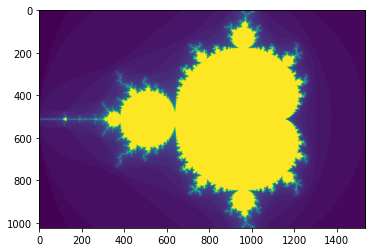

In [ ]:
# PYTHON PURO
import matplotlib.pyplot as plt
import numpy as np

# color function for point at (x, y)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters
    
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt = timer() - start

print ("Mandelbrot creado en el CPU en %f segundos" % dt)
plt.imshow(gimage);

Mandelbrot creado en el CPU optimizado en 0.273661 segundos


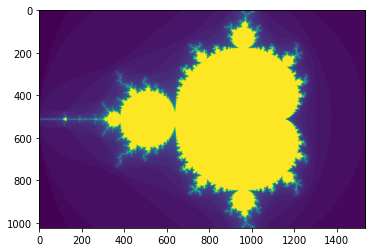

In [ ]:
# CON NUMBA EN CPU

import numba
mandel_numba = numba.jit(mandel)
@numba.jit
def create_fractal_numba(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x]  = color
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal_numba(xmin, xmax, ymin, ymax, gimage, iters)
dt = timer() - start

print ("Mandelbrot creado en el CPU optimizado en %f segundos" % dt)
plt.imshow(gimage)

Mandelbrot creado en el CPU optimizado en 0.005889 segundos


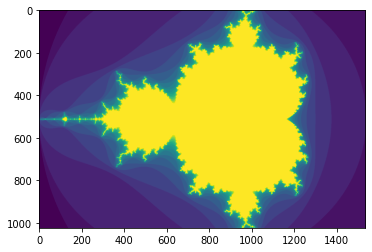

In [ ]:
# CON NUMBA EN GPU
from numba import cuda
from numba import *
import matplotlib.pyplot as plt

@cuda.jit(argtypes=[f8, f8, f8, f8, uint8[:,:], uint32])
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 20) 
d_image.to_host()
dt = timer() - start

print ("Mandelbrot creado en el CPU optimizado en %f segundos" % dt)
plt.imshow(gimage)

## Kernels

Una función del tipo **Kernel** es una función de GPU que debe llamarse desde el código de la CPU$^{1}$ . Esta tiene dos características fundamentales:

1.   Las funciones de tipo **Kernel** no pueden devolver explícitamente un valor; todos los datos de resultado deben escribirse en una matriz que se pasa a la función (si calcula un escalar, probablemente pasará una matriz de un elemento).
2.   En una función de tipo **Kernel** se declara explícitamente su jerarquía de subprocesos cuando se les llama: es decir, el número de bloques de subprocesos y el número de subprocesos por bloque (hay que tener en cuenta que, si bien un kernel se compila una vez, se puede llamar varias veces con diferentes tamaños de bloque o tamaños de grid).

Nota (1): Los dispositivos CUDA más nuevos admiten el lanzamiento del kernel del lado del dispositivo; esta característica se llama paralelismo dinámico pero Numba no la admite actualmente).

A primera vista, escribir un función tipo kernel CUDA con Numba se parece mucho a escribir una función JIT para la CPU:

El decorador @cuda.jit, le indica al interprete de python que esta función debe **traducirse a código de máquina** y por lo tanto su ejecución sera mucho más rapida.

In [ ]:
@cuda.jit
def incremento_en_uno(arreglo):
    """
    incrementa en uno los valores de un arreglo.
    """
    # el codigo de este kernel va a aqui

## Lanzamiento de kernels

Cuando se ejecuta (o lanza) una función de tipo kernel, se tiene que indicar el número de [hilos](https://1984.lsi.us.es/wiki-ssoo/index.php/Hilos) (procesos ligeros) que se van a encargar de ejecutar este kernel en paralelo.

Hay dos maneras usuales de lanzar un Kernel en numba. 

###Forma 1 de lanzar kernel:

In [ ]:
# dimension del grid (matriz)
griddim = 1, 2
# tamano del bloque de ejecucion
blockdim = 3, 4
#llamada (lanzamiento) del kernel
incremento_en_uno[griddim, blockdim](arreglo)

Que sería similar a cuando lanzas un *kernel* en Cuda C.Cómo se puede apreciar a continuación:

In [ ]:
dim3 griddim(1, 2);
dim3 blockdim(3, 4);
increment_by_one<<<griddim, blockdim>>>(aryA);

griddim es el número de bloques de subprocesos por grid. Puede ser:



*   Un entero.
*   Una 1-tupla de enteros.
*   Una 2-tupla de enteros.

blockdim es el número de subprocesos por bloque. Puede ser:

*   Un entero.
*   Una 1-tupla de enteros.
*   Una 2-tupla de enteros.
*   Una 3-tupla de enteros.


###Forma 2 de lanzar kernel:

In [ ]:
threadsperblock = 32
blockspergrid = (an_array.size + (threadsperblock - 1)) // threadsperblock
increment_by_one[blockspergrid, threadsperblock](an_array)

Note dos cosas:



*   Cree una instancia del kernel propiamente dicho, especificando un número de bloques (o "bloques por cuadrícula") y un número de subprocesos por bloque. El producto de los dos dará el número total de hilos lanzados. La instanciación del kernel se realiza tomando la función del kernel compilada (aquí increment_by_one) e indexándola con una tupla de enteros.
*   Ejecutando el kernel, pasándole la matriz de entrada (y cualquier matriz de salida separada si es necesario). Por defecto, ejecutar un kernel es sincrónico: la función regresa cuando el kernel ha terminado de ejecutarse y los datos se vuelven a sincronizar.



###Forma 3 de lanzar Kernel.

En ocasiones queremos ser específicos con los datos que enviamos a los Kernel, debido a eso, a los decoradores de Numba les podemos pasar el tipo de dato que se procesará. Por ejemplo:

In [ ]:
@cuda.jit('void(int32[:], int32[:])')
def foo(aryA, aryB):
    " Process some data "

En la función anterior, le decimos al programa que ingresamos dos 1D-arreglos de tipo entero ( int32[:] , int32[:] ) y extraemos ninguna información ( void ).

También podemos lanzar un kernel, extrayendo algún dato, como se visualiza a continuación.

In [ ]:
@cuda.jit('int32(int32, int32)', device=True)
def bar(a, b):
    " here computes the sum "

En la función anterior, le decimos al programa que ingresamos dos datos de tipo entero ( int32 , int32 ) y extraemosotro dato de tipo entero ( int32 ).

In [ ]:
@cuda.jit('void(int32[:], int32[:], int32[:])')
def use_bar(aryA, aryB, aryOut):
    i = cuda.grid(1) # global position of the thread for a 1D grid.
    aryOut[i] = bar(aryA[i], aryB[i])

##Tamaño del bloque.

Puede parecer curioso tener una jerarquía de dos niveles al declarar el número de subprocesos que necesita un Kernel. El tamaño del bloque (es decir, el número de subprocesos por bloque) suele ser crucial:



*   En el lado del software, el tamaño del bloque determina cuántos subprocesos comparten un área determinada de memoria compartida.
*   En el lado del hardware, el tamaño del bloque debe ser lo suficientemente grande para la ocupación completa de las unidades de ejecución; Las recomendaciones se pueden encontrar en la Guía de programación CUDA C

Para ayudar a lidiar con matrices multidimensionales, CUDA le permite especificar bloques y cuadrículas multidimensionales.

##Posición del Hilo (Subproceso).

Cuando se ejecuta un kernel, el código de la función del kernel es ejecutado por cada hilo una vez. Por lo tanto, tiene que saber en qué hilo se encuentra, para saber de qué elemento (s) de la matriz es responsable (los algoritmos complejos pueden definir responsabilidades más complejas, pero el principio subyacente es el mismo).

Una forma es que el hilo determine su posición en la grid y en el bloque y calcule manualmente la posición de la matriz correspondiente:

Para un 1D grid:

In [ ]:
tx = cuda.threadIdx.x
bx = cuda.blockIdx.x
bw = cuda.blockDim.x
i = tx + bx * bw
array[i] = something(i)

Para un 2d grid:

In [ ]:
tx = cuda.threadIdx.x
ty = cuda.threadIdx.y
bx = cuda.blockIdx.x
by = cuda.blockIdx.y
bw = cuda.blockDim.x
bh = cuda.blockDim.y
x = tx + bx * bw
y = ty + by * bh
array[x, y] = something(x, y)

Una implementación en código de lo anterior sería: 

In [ ]:
@cuda.jit
def increment_by_one(an_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    pos = tx + ty * bw
    if pos < an_array.size:  # Check array boundaries
        an_array[pos] += 1


threadIdx, blockIdx, blockDim and gridDim son objetos especiales proporcionados por el backend CUDA con el único propósito de conocer la geometría de la jerarquía de subprocesos y la posición del subproceso actual dentro de esa geometría.

Estos objetos pueden ser 1D, 2D o 3D, dependiendo de cómo se invocó el kernel. Para acceder al valor en cada dimensión, use los atributos x, y y z de estos objetos, respectivamente.

###**numba.cuda.threadIdx**

Los índices de hilo en el bloque de hilo actual. Para bloques 1D, el índice (dado por el atributo x) es un número entero que abarca el rango de 0 inclusive a **numba.cuda.blockDim** exclusivo. Existe una regla similar para cada dimensión cuando se utiliza más de una dimensión.

###**numba.cuda.blockDim**



La forma del bloque de subprocesos, como se declaró al crear una instancia del kernel. Este valor es el mismo para todos los subprocesos en un kernel dado, incluso si pertenecen a bloques diferentes (es decir, cada bloque está "lleno").

###**numba.cuda.blockIdx**

Los índices de bloque en la cuadrícula de subprocesos lanzaron un kernel. Para una cuadrícula 1D, el índice (dado por el atributo x) es un número entero que abarca el rango de 0 inclusive a **numba.cuda.gridDim** exclusivo. Existe una regla similar para cada dimensión cuando se utiliza más de una dimensión.

###**numba.cuda.gridDim**

La forma de la grid de bloques, es decir, el número total de bloques lanzados por esta invocación del kernel, como se declaró al crear una instancia del kernel.

##Posición del Hilo (Subproceso) de manera compacta.

###**numba.cuda.grid(ndim)**

Devuelve la posición absoluta del hilo actual en toda la cuadrícula de **blocks. ndim** debe corresponder al número de dimensiones declaradas al crear una instancia del kernel. Si **ndim** es 1, se devuelve un solo entero. Si **ndim** es 2 o 3, se devuelve una tupla del número dado de enteros.


###**numba.cuda.gridsize(ndim)**
Devuelve el tamaño absoluto (o forma) en hilos de toda la cuadrícula de **blocks. ndim** tiene el mismo significado que en **grid ()** anterior.

Recordando que para un 1D-grid se tenia el siguiente código:

In [ ]:
tx = cuda.threadIdx.x
bx = cuda.blockIdx.x
bw = cuda.blockDim.x
i = tx + bx * bw
array[i] = something(i)

Con la notación compacta de **cuda.grid** queda de la siguiente manera.

Para un 1D-grid:

In [ ]:
i = cuda.grid(1)
array[i] = something(i)

Recordando que para un 2D-grid se tenia el siguiente código:

In [ ]:
tx = cuda.threadIdx.x
ty = cuda.threadIdx.y
bx = cuda.blockIdx.x
by = cuda.blockIdx.y
bw = cuda.blockDim.x
bh = cuda.blockDim.y
x = tx + bx * bw
y = ty + by * bh
array[x, y] = something(x, y)

Con la notación compacta de **cuda.grid** queda de la siguiente manera.

Para un 2D-grid:

In [ ]:
x, y = cuda.grid(2)
array[x, y] = something(x, y)

Una implementación para:

In [ ]:
@cuda.jit
def increment_by_one(an_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    pos = tx + ty * bw
    if pos < an_array.size:  # Check array boundaries
        an_array[pos] += 1

Con la notación compacta de **cuda.grid** queda de la siguiente manera.

Para un 1D-grid:

In [ ]:
@cuda.jit
def increment_by_one(an_array):
    pos = cuda.grid(1)
    if pos < an_array.size:
        an_array[pos] += 1

Para un 2D-grid:

In [ ]:
@cuda.jit
def increment_a_2D_array(an_array):
    x, y = cuda.grid(2)
    if x < an_array.shape[0] and y < an_array.shape[1]:
       an_array[x, y] += 1

La inicialización de este kernel podría ser la siguiente: 

In [ ]:
threadsperblock = (16, 16)
#  math.ceil take the integer closets 
blockspergrid_x = math.ceil(an_array.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(an_array.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
increment_a_2D_array[blockspergrid, threadsperblock](an_array)

##Ejemplos.

###Código 1.

In [ ]:
from numba import cuda
import numpy as np
@cuda.jit
def increment_by_one(an_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    pos = tx + ty * bw
    if pos < an_array.size:  # Check array boundaries
        an_array[pos] += 1

n = 32
x = np.arange(n).astype(np.float32)
threads_per_block=32
blocks_per_grid=1
print("Antes de lanzar el Kernel")
print(x)
increment_by_one[threads_per_block,blocks_per_grid](x)
print("Despues de lanzar el Kernel")
print(x)

Antes de lanzar el Kernel
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]
Despues de lanzar el Kernel
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]


###Código 2.

In [ ]:
from numba import cuda
import numpy as np
@cuda.jit
def increment_by_one(an_array):
  pos=cuda.grid(1)
  if pos < an_array.size:  # Check array boundaries
    an_array[pos] += 1

n = 32
x = np.arange(n).astype(np.float32)
threads_per_block=32
blocks_per_grid=1
print("Antes de lanzar el Kernel")
print(x)
increment_by_one[threads_per_block,blocks_per_grid](x)
print("Despues de lanzar el Kernel")
print(x)

Antes de lanzar el Kernel
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]
Despues de lanzar el Kernel
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]


###Código 3.

In [ ]:
from __future__ import division
from numba import cuda
import numpy
import math

# CUDA kernel
@cuda.jit('void(float32[:])')
def my_kernel(io_array):
    pos = cuda.grid(1)
    if pos < io_array.size:
        io_array[pos] *= 2 # do the computation

# Host code   
data = numpy.ones(256).astype(np.float32)
threadsperblock = 256
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
my_kernel[blockspergrid, threadsperblock](data)
print(data)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


###Código 4.

In [ ]:
from numba import cuda
import numpy as np 
import math 
@cuda.jit
def sum_arrays(x_in,y_in):
  tId=cuda.threadIdx.x
  bId=cuda.blockIdx.x
  DimBloc=cuda.blockDim.x

  pos=tId+bId*DimBloc

  if pos<x_in.size:
    x_in[pos]=x_in[pos]+y_in[pos]


n = 32
x = np.arange(n).astype(np.float32)
y=np.arange(n).astype(np.float32)

threads_per_block=32
blocks_per_grid=math.ceil(x.size/threads_per_block)

print("Antes de lanzar el Kernel")
print(x)

sum_arrays[blocks_per_grid,threads_per_block](x,y)
print("Despues de lanzar el Kernel")
print(x)

Antes de lanzar el Kernel
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]
Despues de lanzar el Kernel
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60. 62.]


###Código 5.

In [ ]:
@cuda.jit
def add_kernel(x, y, out):
    tidx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    bidx = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_dimx = cuda.blockDim.x  # number of threads per block
    grid_dimx = cuda.gridDim.x    # number of blocks in the grid
    
    start = tidx + bidx * block_dimx
    stride = block_dimx * grid_dimx

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

The slowest run took 85.38 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.01 ms per loop
[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


In [ ]:
@cuda.jit
def add_kernel(x, y, out):
    tidx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    bidx = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_dimx = cuda.blockDim.x  # number of threads per block
    grid_dimx = cuda.gridDim.x    # number of blocks in the grid
    
    start = tidx + bidx * block_dimx
    stride = block_dimx * grid_dimx

    # assuming x and y inputs are same length
    if start<x.size:
        out[start] = x[start] + y[start]

n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

The slowest run took 62.54 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.04 ms per loop
[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


In [ ]:
@cuda.jit
def add_kernel(x, y, out):
    start = cuda.grid(1)

    # assuming x and y inputs are same length
    if start<x.size:
        out[start] = x[start] + y[start]

n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

The slowest run took 61.80 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.02 ms per loop
[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


##Matrices

###Código 1

In [ ]:
@cuda.jit
def increment_a_2D_array(an_array):
    x, y = cuda.grid(2)
    if x < an_array.shape[0] and y < an_array.shape[1]:
       an_array[x, y] += 1

n = 1024
x = np.arange(n).astype(np.float32).reshape((32,32))

threads_per_block = 16
blockdim=threads_per_block , threads_per_block

griddim=math.ceil(n/ blockdim[0]), math.ceil(n/ blockdim[1])

increment_a_2D_array[griddim, blockdim](x)
print(x[:10])

[[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
   15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
   29.  30.  31.  32.]
 [ 33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
   47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.
   61.  62.  63.  64.]
 [ 65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.
   79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.
   93.  94.  95.  96.]
 [ 97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
  111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
  125. 126. 127. 128.]
 [129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
  143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156.
  157. 158. 159. 160.]
 [161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174.
  175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188.
  189. 190. 191. 192.

###Código 2

In [ ]:
@cuda.jit
def increment_a_2D_array(an_array,an_array1):
    x, y = cuda.grid(2)
    if x < an_array.shape[0] and y < an_array.shape[1]:
       an_array[x, y] = an_array[x, y] + an_array1[x, y]

n = 1024
x = np.arange(n).astype(np.float32).reshape((32,32))
y=np.arange(n).astype(np.float32).reshape((32,32))
threads_per_block = 16
blockdim=threads_per_block , threads_per_block

griddim=math.ceil(n/ blockdim[0]), math.ceil(n/ blockdim[1])
print(griddim)
increment_a_2D_array[griddim, blockdim](x,y)
print(x[:10])

(64, 64)
[[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
   28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
   56.  58.  60.  62.]
 [ 64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.  90.
   92.  94.  96.  98. 100. 102. 104. 106. 108. 110. 112. 114. 116. 118.
  120. 122. 124. 126.]
 [128. 130. 132. 134. 136. 138. 140. 142. 144. 146. 148. 150. 152. 154.
  156. 158. 160. 162. 164. 166. 168. 170. 172. 174. 176. 178. 180. 182.
  184. 186. 188. 190.]
 [192. 194. 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216. 218.
  220. 222. 224. 226. 228. 230. 232. 234. 236. 238. 240. 242. 244. 246.
  248. 250. 252. 254.]
 [256. 258. 260. 262. 264. 266. 268. 270. 272. 274. 276. 278. 280. 282.
  284. 286. 288. 290. 292. 294. 296. 298. 300. 302. 304. 306. 308. 310.
  312. 314. 316. 318.]
 [320. 322. 324. 326. 328. 330. 332. 334. 336. 338. 340. 342. 344. 346.
  348. 350. 352. 354. 356. 358. 360. 362. 364. 366. 368. 370. 372. 374.
  376. 378. 

## Referencias

*   https://numba.pydata.org/numba-doc/dev/user/jit.html
*   https://thedatafrog.com/en/articles/make-python-fast-numba/
*   https://people.duke.edu/~ccc14/sta-663/CUDAPython.html



